**Task 3​: write a datajoint pipeline, as you have outlined in (2). As a guiding tutorial, we have provided you with the file ​datajoint_example.ipynb​ . Remember to include a “computed” blocks, including the one for the log-Gaussian and the Poissonian fit.**

In [390]:
import datajoint as dj
import pylab as pl
import numpy as np
from scipy import stats
import os
%matplotlib inline

I downloaded the Docker image of the MySQL database

In [400]:
dj.conn()

DataJoint connection (disconnected) root@localhost:3306

## 1) Defining the relational structure of the database

Define the schema to work in. 

In [392]:
schema = dj.schema('neuron_test6') 

/Users/athoag/.conda/envs/finance/lib/python3.7/site-packages/datajoint/connection.py:150: UserWarning: Mysql server has gone away. Reconnecting to the server.
  warnings.warn("Mysql server has gone away. Reconnecting to the server.")


## Relational structure

Let's start with the same types of tables as in the example: Lookup, Manual, Imported. 

User() and Experiment() are the same as in the example, but the Set() table is different because we need to ingest the 8 data files.

In [396]:
@schema
class User(dj.Lookup):
    definition = """
    # users in the lab
    username : varchar(20)      # user in the lab
    ---
    first_name  : varchar(20)   # user first name
    last_name   : varchar(20)   # user last name
    """
    contents = [
        ['Angus', 'Angus', 'Macguyver'],
        ['John', 'John', 'Doe'],
    ]

@schema
class Experiment(dj.Manual):
    definition = """ # The neuron spike experiments of Angus and John
    -> User
    experiment : int    # allowed here are sql datatypes.
    ----
    """
    
@schema
class Set(dj.Imported):
    definition = """
    # A set of datapoints
    -> Experiment
    -----
    """

    class DataPoint(dj.Part):
        definition = """
        # Collected data.
        -> Set
        datapoint : int
        -----
        x : float
        y : float
        """

    def _make_tuples(self, key):
        # This allows to call a method s.populate() to
        # automatically populate the data with content
        # from the experiment data files
        # The key is a dict for each row in the Experiment table, e.g.:
        # {'username': 'Angus', 'experiment': 0}
        
        self.insert1(key)
        username = key['username']
        experiment = key['experiment']

        # Get data from the data file for this username/experiment combo
        filename = './data/{0}_experiment_{1}.dat'.format(username.lower(),experiment)
        data = np.genfromtxt(filename)
        tbins = np.arange(0, 60, 0.00005) # 1 min recording with 50 microsecond intervals
        b=[]
        for i in range(len(data)):
            # username, experiment, datapoint_index, x, y
            b.append(dict(key, datapoint=i, x=tbins[i],y=data[i]))
        self.DataPoint().insert(b)

## Enter in the experiments for Angus and John
From the downloaded .dat files, we have 3 experiments for Angus and 5 for John. Let's enter those into the Experiment table.

In [118]:
Experiment().insert((['Angus',0],['John',0]), skip_duplicates = True)
Experiment().insert((['Angus',1],['John',1]), skip_duplicates = True)
Experiment().insert((['Angus',2],['John',2]), skip_duplicates = True)
Experiment().insert((['John',3],['John',4]), skip_duplicates = True)

In [395]:
Experiment()

username user in the lab,experiment allowed here are sql datatypes.
Angus,0
Angus,1
Angus,2
John,0
John,1
John,2
John,3
John,4


**Task 4​: After constructing the database, populate it with all the datafiles in the /data folder (use populate).**

I will include the Computed tables below, but before I do that I can already populate the Set() table

In [120]:
Set().populate()

In [144]:
Set() # Now there are 8 datasets in the database

username user in the lab,experiment allowed here are sql datatypes.
Angus,0
Angus,1
Angus,2
John,0
John,1
John,2
John,3
John,4


In [145]:
Set().DataPoint() # With a set of datapoints

username user in the lab,experiment allowed here are sql datatypes.,datapoint,x,y
Angus,0,0,0.0,-0.0700399
Angus,0,1,5e-05,-0.82838
Angus,0,2,0.0001,0.60465
Angus,0,3,0.00015,1.08835
Angus,0,4,0.0002,-0.370709
Angus,0,5,0.00025,-1.1994
Angus,0,6,0.0003,1.95765
Angus,0,7,0.00035,-0.0699648
Angus,0,8,0.0004,4.39331
Angus,0,9,0.00045,-0.0692801


## Add a table for computing the peak interval distribution

Let's add a new table, Peakhist() to the database that calculates the peak interval distribution from the data points stored in the Set().DataPoint() table. The table is of type Computed because it only depends on data internal to the database, i.e. it can be recreated easily without external data.

In [331]:
@schema
class Peakhist(dj.Computed):
    definition = """
    # calculates the peak interval histogram
    -> Set
    -----
    """

    class DataPoint(dj.Part):
        definition = """
        # Collected data.
        -> Peakhist
        datapoint : int
        -----
        bin_cen : float
        prob : float
        """

    def _make_tuples(self, key):
        # This allows to call a method s.populate()
        
        self.insert1(key)
        data  = (Set().DataPoint() & key)
        x, y = data.fetch('x','y') # time step and voltage
        threshold = -3*np.std(y) # use -3 standard deviations because -5 gave zero spikes for John, 1
        above = (y < threshold)
        spikes = above[1:] < above[0:-1]
        spikeTimes = x[np.where(spikes)]
        spikeVoltages = y[np.where(spikes)]
        ISI = np.diff(spikeTimes)
        Ns,bin_edges = np.histogram(ISI*1000, bins=30)
        probabilities = Ns/np.sum(Ns)
        bin_cens = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
        b = []
        for i in range(len(bin_cens)):
            b.append(dict(key,datapoint=i,bin_cen=bin_cens[i], prob=probabilities[i]))
        self.DataPoint().insert(b)

In [296]:
Peakhist().populate()

Now we are ready to fit the models to the data

## Log-normal fitter
Here we add a Computed-type table to calculate and store the best-fit parameters of a log-normal to the peak interval distribution we found with the Peakhist() table.

In [298]:
import scipy.optimize as opt
import scipy as sc

def normpdf(x, mu, sd, denom):
    num = np.exp(-(x-mu)**2/(2*sd*sd))
    return num/denom

In [397]:
@schema
class Lognormal(dj.Computed):
    definition = """
    # calculates the fitparameters of the log normal
    -> Set
    -----
    mu    : float
    sd    : float
    denom : float
    """
    
    def _make_tuples(self, key):
        data  = (Peakhist().DataPoint() & key)
        bin_cens, probs = data.fetch('bin_cen','prob')
        try: # had to add this because in one experiment the fit was unsuccessful 
            popt, pcov = opt.curve_fit(normpdf, np.log(bin_cens), probs,maxfev=10000)
            mu,sd,denom=popt
        # In the case of an unsuccessful fit,
        # we need to provide an entry. I chose fit values of 
        # -9999 as this is unphysical, but a masked or non-numeric value might be 
        # better as -9999 will still show up in a query.
        except RuntimeError: 
            mu,sd,denom = -9999,-9999,-9999

        self.insert1(dict(key, mu = mu, sd = sd, denom = denom))

/Users/athoag/.conda/envs/finance/lib/python3.7/site-packages/datajoint/connection.py:150: UserWarning: Mysql server has gone away. Reconnecting to the server.
  warnings.warn("Mysql server has gone away. Reconnecting to the server.")


In [340]:
Lognormal().populate()

In [341]:
Lognormal()

username user in the lab,experiment allowed here are sql datatypes.,mu,sd,denom
Angus,0,-24.7348,5.29388,1.87926e-06
Angus,1,-9999.0,-9999.0,-9999.0
Angus,2,-7.54368,3.43212,0.017477
John,0,-8.04115,3.71012,0.0374183
John,1,1.7662,1.27888,4.70378
John,2,-28.2885,5.87997,2.17972e-06
John,3,-1.48691,2.56832,0.536715
John,4,-11.419,3.89478,0.00167759


# Adding the Poisson fitter
To add in a class that calculates the best-fit Poisson distribution to the spike interval histogram, I would add another Computed table, like the one for Lognormal(). However, I can't use the same binned data that I made with Peakhist() because to fit a Poisson I need bins with integer values. I therefore need to first create a new Computed table like Peakhist() but which will bin the data properly for the Poisson fitter. Let's call this table Peakhist_4Poisson()

In [399]:
@schema
class Peakhist_4Poisson(dj.Computed):
    definition = """
    # calculates the peak interval histogram, 
    # in bins that will be appropriate for fitting 
    # to a Poisson distribution
    -> Set
    -----
    """

    class DataPoint(dj.Part):
        definition = """
        # Collected data.
        -> Peakhist_4Poisson
        datapoint : int
        -----
        bin_cen : float
        prob : float
        """

    def _make_tuples(self, key):
        # This allows to call a method s.populate() to
        # automatically populate the data with content
        
        self.insert1(key)
        data  = (Set().DataPoint() & key)
        x, y = data.fetch('x','y') # time step and voltage
        threshold = -3*np.std(y) # use -3 standard deviations because -5 gave zero for John, 1
        above = (y < threshold)
        spikes = above[1:] < above[0:-1]
        spikeTimes = x[np.where(spikes)]
        spikeVoltages = y[np.where(spikes)]
        ISI = np.diff(spikeTimes)
        bins = range(0,16,1) # Need to be integers
        Ns,bins,_ = np.histogram(ISI*10,bins=bins)
        probabilities = Ns/np.sum(Ns)
        bin_cens = np.array([int((bins[i]+bins[i+1])/2.) for i in range(len(bins)-1)])
        b = []
        for i in range(len(bin_cens)):
            b.append(dict(key,datapoint=i,bin_cen=bin_cens[i], prob=probabilities[i]))
        self.DataPoint().insert(b)

Now I can make the Poisson() table which will compute and store the Poisson means for each experiment. I make sure to grab data from the Peakhist_4Poisson() table here.

In [ ]:
from scipy.special import factorial
def poisson_model(x, lamb):
    return (lamb**x/factorial(x)) * np.exp(-lamb)

In [ ]:
@schema
class Poisson(dj.Computed):
    definition = """
    # calculates the mean of the best-fit Poisson distribution
    -> Set
    -----
    mu    : float
    """
    
    def _make_tuples(self, key):
        data  = (Peakhist_4Poisson().DataPoint() & key)
        bin_cens, probs = data.fetch('bin_cen','prob')
        try:
            popt, pcov = opt.curve_fit(poisson_model, bin_cens, probs,maxfev=10000)
            mu=popt[0]
        except RuntimeError:
            mu = -9999

        self.insert1(dict(key, mu = mu))

/Users/athoag/.conda/envs/finance/lib/python3.7/site-packages/datajoint/connection.py:150: UserWarning: Mysql server has gone away. Reconnecting to the server.
  warnings.warn("Mysql server has gone away. Reconnecting to the server.")


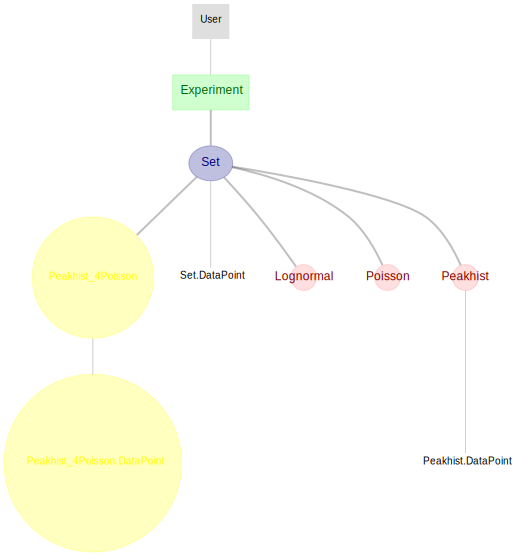

In [401]:
# Finally, we can see the entity relationship diagram:
dj.ERD(schema)

**Task 5​: As all data is now managed with a SQL backend, how would you query this data from the database directly? Provide the queries to (a) get the means of the Gaussian fits**

In [348]:
Lognormal().fetch('mu') # gets the means of the log-normal fits to the 8 experiments

array([-2.47348e+01, -9.99900e+03, -7.54368e+00, -8.04115e+00,
        1.76620e+00, -2.82885e+01, -1.48691e+00, -1.14190e+01])

**(b) get all Experiments with at least 50 spikes.**

In [384]:
usernames,experiments=Experiment().fetch('username','experiment')
for i in range(len(usernames)):
    username=usernames[i]
    experiment=experiments[i]
    data = Set().DataPoint() & {'username':username,'experiment':experiment}
    y=data.fetch('y')
    threshold = -3*np.std(y) # use 3 standard deviations because 5 gave zero for John, 1
    above = (y < threshold)
    spikes = above[1:] < above[0:-1]
    spikeVoltages = y[np.where(spikes)]
    if len(spikeVoltages)>50:
        print(username,experiment)

Angus 0
Angus 1
Angus 2
John 0
John 1
John 2
John 3
John 4


Using -3 standard deviations as the threshold, all of the experiments have at least 50 spikes. This is not the case when -5 standard deviations is used as the threshold, so the answer depends on how we choose to set the threshold.

Had we saved spiketimes in a separate table, we would be able to answer this question with a single query to the database.